<a href="https://colab.research.google.com/github/KcRenee/FacialKPR/blob/main/FacialKPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORT LIBRARIES
import zipfile, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [3]:
# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [6]:
# SETUP PATHS AND UNZIP DATA
base_path = "/content/sample_data"
work_path = "/content/sample_data/working"

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Unzip training.zip
with zipfile.ZipFile(f"{base_path}/training.zip", 'r') as zip_ref:
    zip_ref.extractall(work_path)

# Unzip test.zip
with zipfile.ZipFile(f"{base_path}/test.zip", 'r') as zip_ref:
    zip_ref.extractall(work_path)

print("Extracted files:", os.listdir(work_path))

Extracted files: ['training.csv', 'test.csv']


In [8]:
# LOAD CSV FILES
TRAIN_CSV = f"{work_path}/training.csv"
TEST_CSV  = f"{work_path}/test.csv"
LOOKUP_CSV = f"{base_path}/IdLookupTable.csv"

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)
lookup = pd.read_csv(LOOKUP_CSV)

print("TRAIN shape:", train.shape)
print("TEST shape:", test.shape)
print("LOOKUP shape:", lookup.shape)

TRAIN shape: (7049, 31)
TEST shape: (1783, 2)
LOOKUP shape: (27124, 4)


In [9]:
# HELPER FUNCTIONS
def image_from_str(img_str):
    arr = np.array(img_str.split(), dtype="float32")
    return arr.reshape(96, 96)

def prepare_images(df):
    imgs = np.stack(df['Image'].apply(lambda s: image_from_str(s)).values)
    imgs = imgs.astype('float32') / 255.0
    imgs = imgs.reshape(-1, 96, 96, 1)
    return imgs

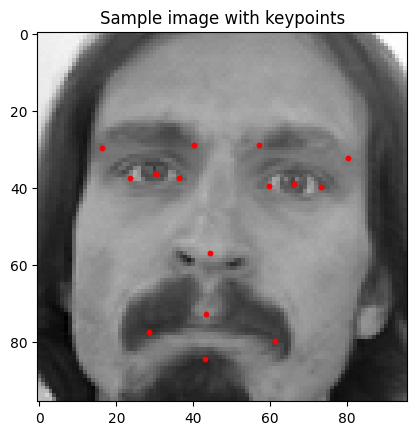

In [10]:
# VISUALIZE SAMPLE IMAGE
sample = train.dropna().iloc[0]
img = image_from_str(sample['Image'])
plt.imshow(img, cmap='gray')
kp = sample.drop('Image').values.astype(float)
plt.scatter(kp[0::2], kp[1::2], c='r', s=10)
plt.title("Sample image with keypoints")
plt.show()

In [11]:
# CLEAN AND PREPARE DATA
train_clean = train.dropna().reset_index(drop=True)
print("After dropna:", train_clean.shape)

X = prepare_images(train_clean)
y = train_clean.drop(columns=['Image']).values.astype('float32')
kp_columns = train_clean.drop(columns=['Image']).columns.tolist()
print("Keypoint columns:", kp_columns)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)

After dropna: (2140, 31)
Keypoint columns: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
X_train shape: (1819, 96, 96, 1) X_val shape: (321, 96, 96, 1)


In [12]:
# BUILD CNN MODEL
def build_model():
    model = Sequential([
        Input(shape=(96, 96, 1)),
        Conv2D(32, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Conv2D(64, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Conv2D(128, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(len(kp_columns))  # 30 keypoints
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,407,390 (13.00 MB)

 Trainable params: 3,406,942 (13.00 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
train.isnull().sum()

,0
left_eye_center_x,10
left_eye_center_y,10
right_eye_center_x,13
right_eye_center_y,13
left_eye_inner_corner_x,4778
left_eye_inner_corner_y,4778
left_eye_outer_corner_x,4782
left_eye_outer_corner_y,4782
right_eye_inner_corner_x,4781
right_eye_inner_corner_y,4781


Epoch 1/3


29/29 - 51s - 2s/step - loss: 41.2214 - mae: 4.9935 - val_loss: 1340.0889 - val_mae: 33.8511
Epoch 2/3


29/29 - 79s - 3s/step - loss: 49.0128 - mae: 5.4230 - val_loss: 949.8842 - val_mae: 28.4175
Epoch 3/3


29/29 - 52s - 2s/step - loss: 35.3318 - mae: 4.6037 - val_loss: 676.9327 - val_mae: 23.8098


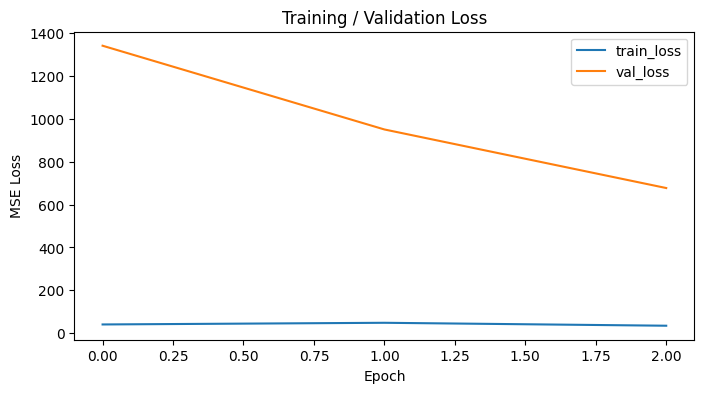

In [17]:
# TRAIN MODEL
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64,
    callbacks=[es, mc],
    verbose=2
)

# Plot training / validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training / Validation Loss')
plt.show()


In [18]:
# PREPARE TEST DATA AND PREDICT
test_images = prepare_images(test)
model.load_weights('best_model.h5')
preds = model.predict(test_images)
print("Predictions shape:", preds.shape)  # should be (n_test, 30)

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step
Predictions shape: (1783, 30)


In [19]:
# CREATE CORRECT SUBMISSION (CLIPPED TO [0,96])
submission = lookup.copy()

submission['Location'] = submission.apply(
    lambda r: np.clip(
        preds[int(r['ImageId']) - 1, kp_columns.index(r['FeatureName'])],
        0, 96  # clip to valid image coordinates
    ),
    axis=1
)

# Keep only RowId and Location columns
submission = submission[['RowId', 'Location']]
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv ready for Kaggle (coordinates clipped to [0,96])!")

✅ submission.csv ready for Kaggle (coordinates clipped to [0,96])!


In [20]:
# ---------- imports ----------
import os
import zipfile
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [32]:
# ---------- CONFIG ----------
DATA_DIR = "/content/sample_data"   # change to your data folder or Drive path
WORK_DIR = "/content/working"       # will be created if missing
SEED = 42
IMG_SIZE = 96
BATCH_SIZE = 64
EPOCHS = 3   # increase to 40-80 for serious training
MODEL_WEIGHTS = "best_model.h5"

In [33]:
# reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [34]:
# ---------- ensure working dir ----------
os.makedirs(WORK_DIR, exist_ok=True)

# ---------- helper: safely unzip if present ----------
def try_unzip(zip_path, extract_to):
    if os.path.exists(zip_path):
        print(f"Unzipping {zip_path} -> {extract_to}")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_to)
    else:
        print(f"No {zip_path} found (skipping).")

try_unzip(os.path.join(DATA_DIR, "training.zip"), WORK_DIR)
try_unzip(os.path.join(DATA_DIR, "test.zip"), WORK_DIR)

Unzipping /content/sample_data/training.zip -> /content/working
Unzipping /content/sample_data/test.zip -> /content/working


In [35]:
# ---------- paths to CSVs (try multiple common locations) ----------
train_csv_candidates = [
    os.path.join(WORK_DIR, "training.csv"),
    os.path.join(DATA_DIR, "training.csv"),
    os.path.join(DATA_DIR, "train.csv"),
    os.path.join(WORK_DIR, "train.csv"),
]
test_csv_candidates = [
    os.path.join(WORK_DIR, "test.csv"),
    os.path.join(DATA_DIR, "test.csv"),
]
lookup_candidates = [
    os.path.join(DATA_DIR, "IdLookupTable.csv"),
    os.path.join(WORK_DIR, "IdLookupTable.csv"),
    os.path.join(DATA_DIR, "IdLookupTable.csv"),
]

def find_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

TRAIN_CSV = find_existing(train_csv_candidates)
TEST_CSV  = find_existing(test_csv_candidates)
LOOKUP_CSV = find_existing(lookup_candidates)

print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV :", TEST_CSV)
print("LOOKUP_CSV:", LOOKUP_CSV)

TRAIN_CSV: /content/working/training.csv
TEST_CSV : /content/working/test.csv
LOOKUP_CSV: /content/sample_data/IdLookupTable.csv


In [36]:
# ---------- load CSVs (if available) ----------
if TRAIN_CSV is None:
    raise FileNotFoundError("Couldn't find training CSV. Upload training.csv or training.zip to DATA_DIR.")
train = pd.read_csv(TRAIN_CSV)

test = None
if TEST_CSV is not None:
    test = pd.read_csv(TEST_CSV)
else:
    print("No test CSV found. Will try to read test images from disk if available.")

lookup = None
if LOOKUP_CSV is not None:
    lookup = pd.read_csv(LOOKUP_CSV)
else:
    print("Warning: IdLookupTable.csv not found. Submission creation will fail unless you provide it.")

print("train.shape:", train.shape)
if test is not None:
    print("test.shape:", test.shape)
if lookup is not None:
    print("lookup.shape:", lookup.shape)

train.shape: (7049, 31)
test.shape: (1783, 2)
lookup.shape: (27124, 4)


In [37]:
# ---------- helper: parse Kaggle 'Image' column safely ----------
def image_from_str(img_str):
    # sometimes there are leading/trailing spaces; split is robust
    arr = np.array(img_str.strip().split(), dtype=np.float32)
    if arr.size != IMG_SIZE * IMG_SIZE:
        raise ValueError(f"Image string length mismatch: expected {IMG_SIZE*IMG_SIZE}, got {arr.size}")
    return arr.reshape(IMG_SIZE, IMG_SIZE)

def prepare_images_from_series(series):
    imgs = np.stack(series.apply(image_from_str).values)
    imgs = imgs.astype('float32') / 255.0
    imgs = imgs.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return imgs

In [38]:
# ---------- prepare training data ----------
# Drop rows with all NaNs in keypoints, but we'll impute columns with missing values
img_col = 'Image'
if img_col not in train.columns:
    raise KeyError("Training CSV must contain an 'Image' column of flattened pixels.")

# collect keypoint columns (all columns except Image)
kp_columns = [c for c in train.columns if c != img_col]
print("Keypoint columns count:", len(kp_columns))

Keypoint columns count: 30


In [39]:
# Convert Image -> numpy, and impute missing keypoint values using column mean
X_imgs = prepare_images_from_series(train[img_col])
y = train[kp_columns].values.astype('float32')

# Impute missing keypoints with column means (simpler approach)
imputer = SimpleImputer(strategy="mean")
y = imputer.fit_transform(y)

print("X_imgs.shape:", X_imgs.shape, "y.shape:", y.shape)

X_imgs.shape: (7049, 96, 96, 1) y.shape: (7049, 30)


In [40]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_imgs, y, test_size=0.15, random_state=SEED
)
print("X_train:", X_train.shape, "X_val:", X_val.shape)

X_train: (5991, 96, 96, 1) X_val: (1058, 96, 96, 1)


In [41]:
# ---------- build a slightly better CNN ----------
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), n_outputs=None):
    if n_outputs is None:
        raise ValueError("n_outputs must be provided")
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))

    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='linear'))  # regression

    model.compile(optimizer=optimizers.Adam(1e-3), loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model(n_outputs=len(kp_columns))
model.summary()

# ---------- callbacks ----------
es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = callbacks.ModelCheckpoint(MODEL_WEIGHTS, monitor='val_loss', save_best_only=True, save_weights_only=False)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,247,902 (20.02 MB)

 Trainable params: 5,246,942 (20.02 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/3


94/94 - 262s - 3s/step - loss: 115.7010 - mae: 6.8620 - val_loss: 162.4072 - val_mae: 11.2928
Epoch 2/3
94/94 - 250s - 3s/step - loss: 32.8490 - mae: 4.3710 - val_loss: 233.4005 - val_mae: 13.8608
Epoch 3/3
94/94 - 252s - 3s/step - loss: 27.2898 - mae: 3.9703 - val_loss: 330.1158 - val_mae: 16.3997


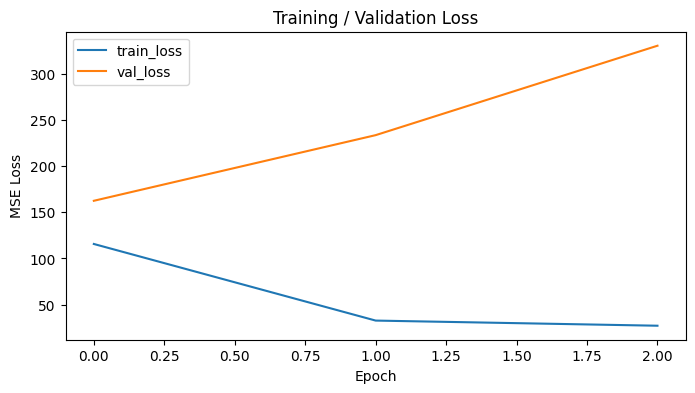

In [42]:
# ---------- training ----------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    verbose=2
)

# ---------- training plots ----------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training / Validation Loss')
plt.show()

In [44]:
# ---------- prepare test data ----------
# Option A: test CSV contains flattened 'Image' column
test_images = None
test_image_ids = None

if test is not None and 'Image' in test.columns:
    print("Preparing test images from test.csv 'Image' column...")
    test_images = prepare_images_from_series(test['Image'])
    # If test has ImageId column or Id, create mapping
    if 'ImageId' in test.columns:
        test_image_ids = test['ImageId'].values
    elif 'ImageId' in lookup.columns if lookup is not None else False:
        test_image_ids = test['ImageId'].values
    else:
        # assume rows are in order with ImageId = 1..n
        test_image_ids = np.arange(1, len(test) + 1)
elif os.path.exists(os.path.join(WORK_DIR, "test")) or os.path.exists(os.path.join(DATA_DIR, "test")):
  # Option B: test images saved individually in a folder (jpg/png). Read and convert to 96x96 grayscale.
    # We'll look for common test folders.
    candidate = os.path.join(WORK_DIR, "test")
    if not os.path.exists(candidate):
        candidate = os.path.join(DATA_DIR, "test")
    print("Preparing test images from files in:", candidate)
    import cv2
    files = sorted(glob.glob(os.path.join(candidate, "*")))
    imgs = []
    ids = []
    for f in files:
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32') / 255.0
        img = img.reshape(IMG_SIZE, IMG_SIZE, 1)
        imgs.append(img)
        # try to extract an id from filename
        name = os.path.splitext(os.path.basename(f))[0]
        try:
            ids.append(int(name))
        except:
            ids.append(len(ids) + 1)
    if len(imgs) == 0:
        raise FileNotFoundError("No test images found in candidate test folders.")
    test_images = np.stack(imgs)
    test_image_ids = np.array(ids)
else:
    raise FileNotFoundError("No test data available: neither test.csv with 'Image' nor test image folder found.")

print("test_images.shape:", test_images.shape)

Preparing test images from test.csv 'Image' column...
test_images.shape: (1783, 96, 96, 1)


In [45]:
# ---------- predict ----------
# Make sure best model weights are loaded (ModelCheckpoint saved entire model)
if os.path.exists(MODEL_WEIGHTS):
    print("Loading saved model weights from", MODEL_WEIGHTS)
    model = tf.keras.models.load_model(MODEL_WEIGHTS)
else:
    print("No saved model found; using current model weights from training run.")

preds = model.predict(test_images)
print("Predictions shape:", preds.shape)  # (n_test, n_keypoints)

Loading saved model weights from best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step
Predictions shape: (1783, 30)


In [46]:
# ---------- create submission using lookup table ----------
if lookup is None:
    print("No IdLookupTable.csv available — cannot construct Kaggle-style submission automatically.")
else:
    # We need to map each row in lookup to the correct prediction value
    # Build a mapping: imageId -> row index in test_images array
    id_to_index = {int(i): idx for idx, i in enumerate(test_image_ids)}

# kp_columns contains the column names in the same order as model outputs
    # Create a function to fetch predicted value for a lookup row
    def lookup_value(row):
        img_id = int(row['ImageId'])
        feature = row['FeatureName']
        if img_id not in id_to_index:
            # fallback: try 1-based position
            idx = img_id - 1
        else:
            idx = id_to_index[img_id]
        try:
            kp_idx = kp_columns.index(feature)
        except ValueError:
            raise ValueError(f"FeatureName {feature} not found in training columns.")
        val = preds[idx, kp_idx]
        # Clip to image boundaries
        return float(np.clip(val, 0, IMG_SIZE))

    submission = lookup.copy()
    submission['Location'] = submission.apply(lookup_value, axis=1)
    submission = submission[['RowId', 'Location']]
    submission.to_csv('submission.csv', index=False)
    print("Saved submission.csv with", submission.shape[0], "rows.")

Saved submission.csv with 27124 rows.


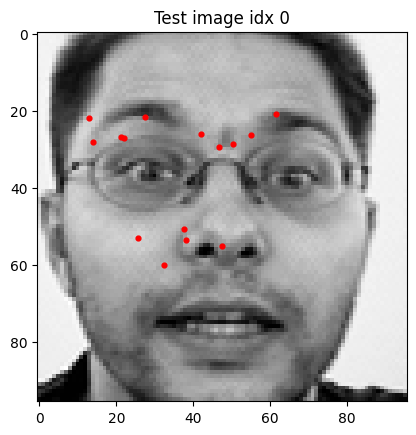

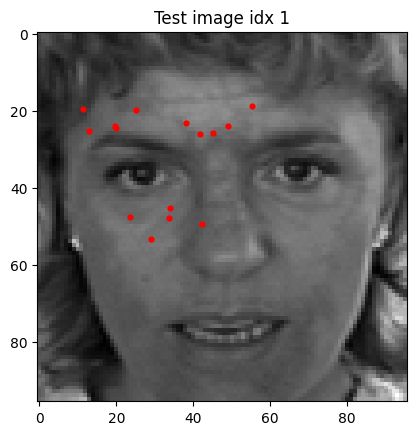

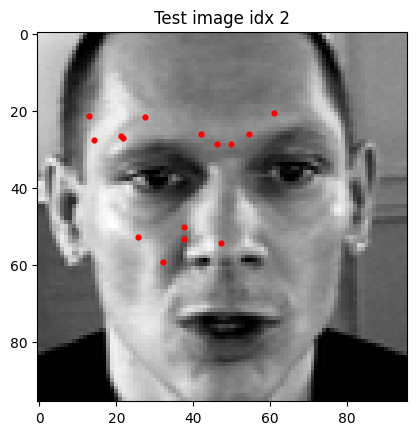

Done.


In [47]:
# ---------- show a few predicted keypoints on test images (sanity) ----------
def show_pred(idx):
    im = test_images[idx].reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(im, cmap='gray')
    vals = preds[idx]
    xs = vals[0::2]
    ys = vals[1::2]
    plt.scatter(xs, ys, c='r', s=12)
    plt.title(f"Test image idx {idx}")
    plt.show()

# show first 3 if available
for i in range(min(3, test_images.shape[0])):
    show_pred(i)

print("Done.")